### **Download and extract Food 101 Dataset**

In [77]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
import requests
import json
from IPython.display import display, HTML

In [78]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.13.0
/device:GPU:0


In [79]:
%cd /kaggle/input/food-101/food-101

/kaggle/input/food-101/food-101


In [80]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

* **Commented the below cell as the Food-101 dataset is available from Kaggle Datasets and need not be downloaded..**

In [81]:
# Download data and extract it to folder

get_data_extract()

Dataset already exists


### **Understand dataset structure and files**

In [82]:
# Check the extracted dataset folder
!ls food-101/

README.txt  images  license_agreement.txt  meta


In [83]:
os.listdir('food-101/images')

['macarons',
 'french_toast',
 'lobster_bisque',
 'prime_rib',
 'pork_chop',
 'guacamole',
 'baby_back_ribs',
 'mussels',
 'beef_carpaccio',
 'poutine',
 'hot_and_sour_soup',
 'seaweed_salad',
 'foie_gras',
 'dumplings',
 'peking_duck',
 'takoyaki',
 'bibimbap',
 'falafel',
 'pulled_pork_sandwich',
 'lobster_roll_sandwich',
 'carrot_cake',
 'beet_salad',
 'panna_cotta',
 'donuts',
 'red_velvet_cake',
 'grilled_cheese_sandwich',
 'cannoli',
 'spring_rolls',
 'shrimp_and_grits',
 'clam_chowder',
 'omelette',
 'fried_calamari',
 'caprese_salad',
 'oysters',
 'scallops',
 'ramen',
 'grilled_salmon',
 'croque_madame',
 'filet_mignon',
 'hamburger',
 'spaghetti_carbonara',
 'miso_soup',
 'bread_pudding',
 'lasagna',
 'crab_cakes',
 'cheesecake',
 'spaghetti_bolognese',
 'cup_cakes',
 'creme_brulee',
 'waffles',
 'fish_and_chips',
 'paella',
 'macaroni_and_cheese',
 'chocolate_mousse',
 'ravioli',
 'chicken_curry',
 'caesar_salad',
 'nachos',
 'tiramisu',
 'frozen_yogurt',
 'ice_cream',
 'ris

In [84]:
os.listdir('food-101/meta')

['test.txt',
 'train.json',
 'labels.txt',
 'test.json',
 'train.txt',
 'classes.txt']

In [85]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [86]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

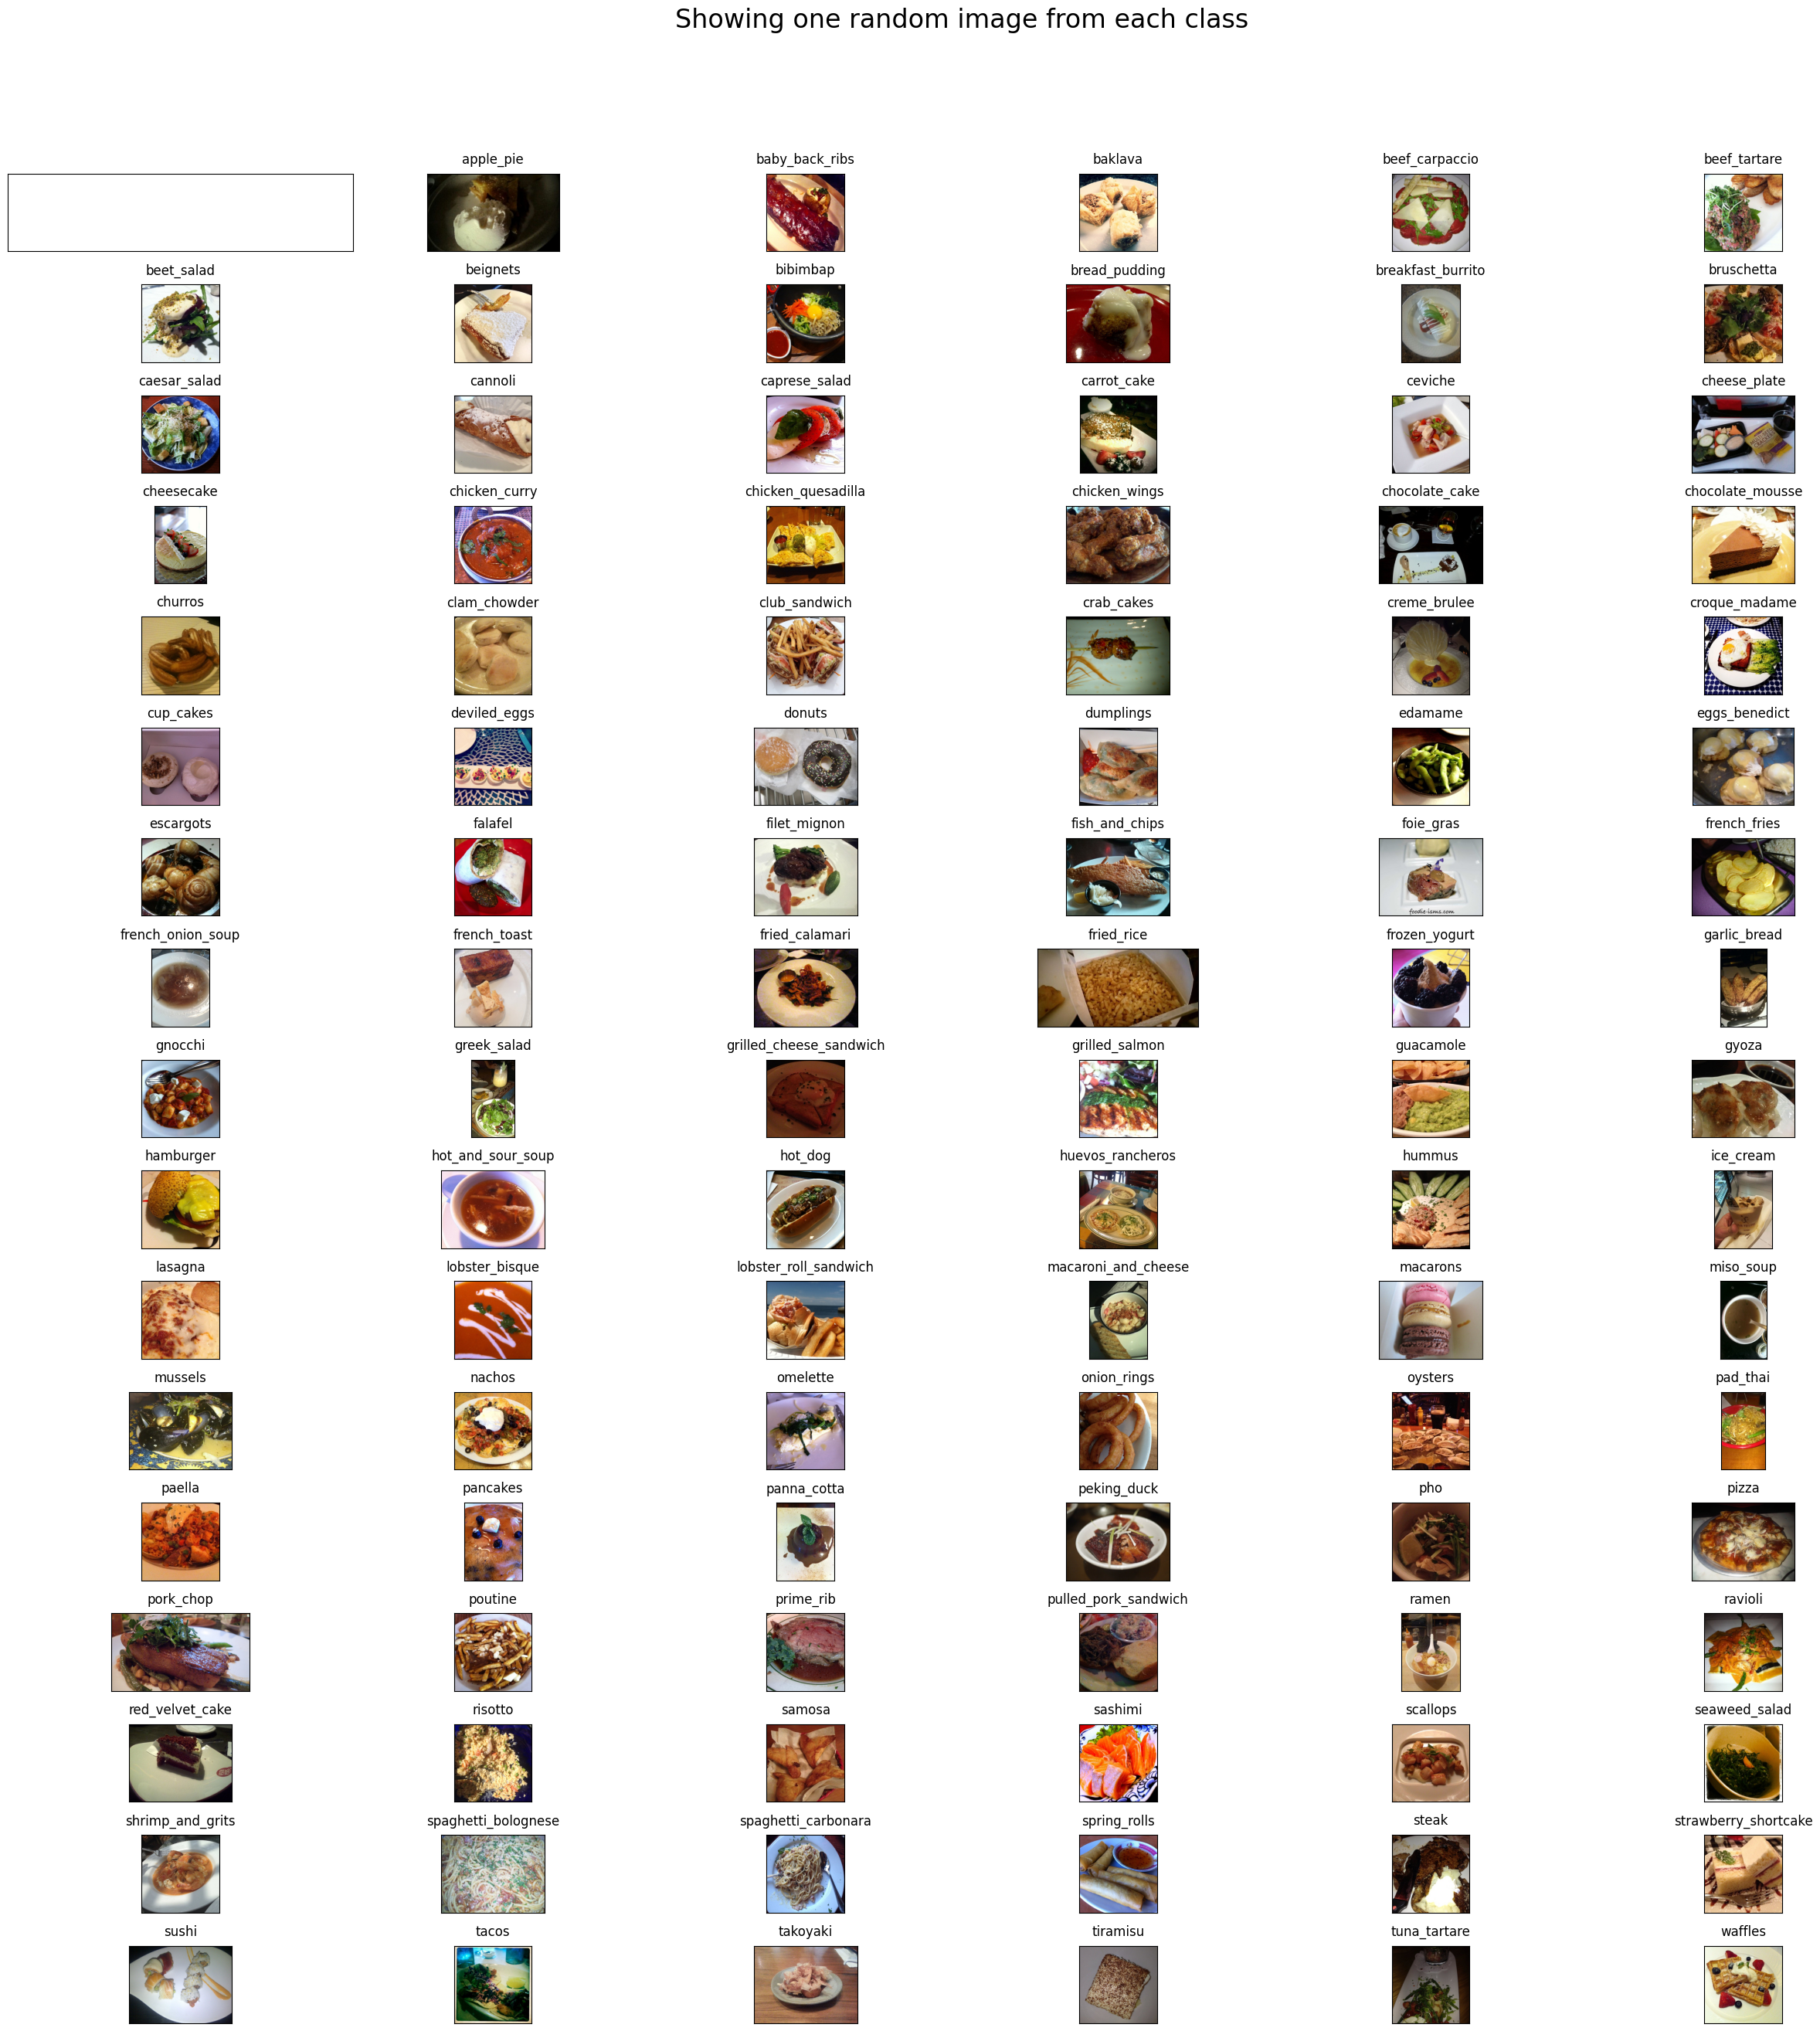

In [87]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


### **Split the image data into train and test using train.txt and test.txt**

In [88]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [89]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /

print("Creating train data...")
prepare_data('/kaggle/input/food-101/food-101/food-101/meta/train.txt', '/kaggle/input/food-101/food-101/food-101/images', 'train')
#food-101/meta/train.txt

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [90]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/kaggle/input/food-101/food-101/food-101/meta/test.txt', '/kaggle/input/food-101/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [91]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [92]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [93]:
os.chdir('/')

### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**

In [94]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [95]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [96]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [97]:
#**************************************************************
#Picking 15 food items(classes) and generating separate data folders for the mini_train and mini_test datasets
food_list = ['apple_pie','pizza','caesar_salad','ramen','churros','steak','chocolate_cake','french_fries','pancakes','lasagna','falafel','sushi','spaghetti_bolognese','tacos','dumplings']
src_train = 'train'
dest_train = '/kaggle/working/train_mini'
src_test = 'test'
dest_test = '/kaggle/working/test_mini'

In [98]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into caesar_salad
Copying images into ramen
Copying images into churros
Copying images into steak
Copying images into chocolate_cake
Copying images into french_fries
Copying images into pancakes
Copying images into lasagna
Copying images into falafel
Copying images into sushi
Copying images into spaghetti_bolognese
Copying images into tacos
Copying images into dumplings


In [99]:
print("Total number of samples in train folder")

!find /kaggle/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
11250


In [100]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into caesar_salad
Copying images into ramen
Copying images into churros
Copying images into steak
Copying images into chocolate_cake
Copying images into french_fries
Copying images into pancakes
Copying images into lasagna
Copying images into falafel
Copying images into sushi
Copying images into spaghetti_bolognese
Copying images into tacos
Copying images into dumplings


In [101]:
print("Total number of samples in test folder")
!find /kaggle/working/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
3750


### **Fine tune ResNet50 Pretrained model using Food 101 dataset**

In [102]:
from tensorflow.keras.applications.resnet50 import ResNet50

K.clear_session()
n_classes = 15
img_width, img_height = 224, 224
train_data_dir = '/kaggle/working/train_mini'
validation_data_dir = '/kaggle/working/test_mini'
nb_train_samples = 11250 #75750
nb_validation_samples = 3750 #25250
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(15,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/kaggle/working/best_model_15class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/kaggle/working/history_15class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('/kaggle/working/model_trained_15class.hdf5')

Found 11250 images belonging to 15 classes.
Found 3750 images belonging to 15 classes.


/tmp/ipykernel_41/219565079.py:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.2637 - accuracy: 0.6501
Epoch 1: val_loss improved from inf to 3.26927, saving model to /kaggle/working/best_model_15class.hdf5
175/175 [==============================] - 169s 872ms/step - loss: 1.2637 - accuracy: 0.6501 - val_loss: 3.2693 - val_accuracy: 0.0665
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.8074
Epoch 2: val_loss improved from 3.26927 to 3.08844, saving model to /kaggle/working/best_model_15class.hdf5
175/175 [==============================] - 163s 929ms/step - loss: 0.7128 - accuracy: 0.8074 - val_loss: 3.0884 - val_accuracy: 0.0660
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.8599
Epoch 3: val_loss did not improve from 3.08844
175/175 [==============================] - 148s 845ms/step - loss: 0.5242 - accuracy: 0.8599 - val_loss: 3.1841 - val_accuracy: 0.0959
Epoch 4/30
175/175 [============================

In [103]:
class_map_15 = train_generator.class_indices
class_map_15

{'apple_pie': 0,
 'caesar_salad': 1,
 'chocolate_cake': 2,
 'churros': 3,
 'dumplings': 4,
 'falafel': 5,
 'french_fries': 6,
 'lasagna': 7,
 'pancakes': 8,
 'pizza': 9,
 'ramen': 10,
 'spaghetti_bolognese': 11,
 'steak': 12,
 'sushi': 13,
 'tacos': 14}

### **Visualize the accuracy and loss plots**

In [104]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

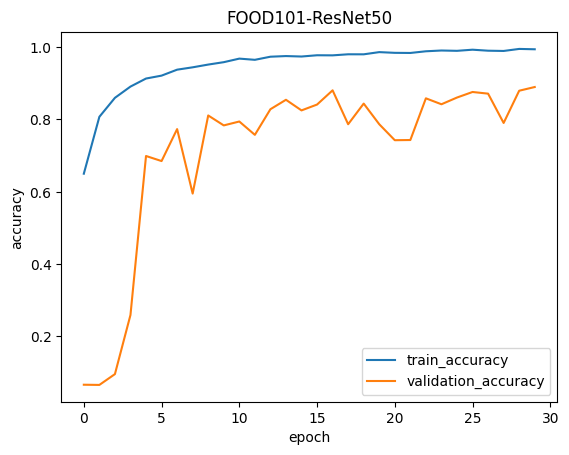

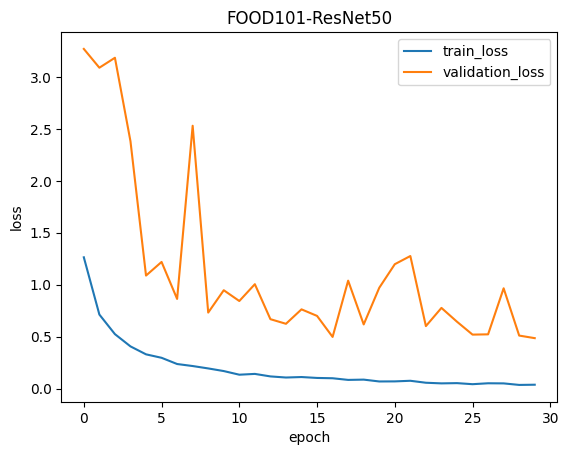

In [105]:
plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

### **Predicting classes for new images from internet using the best trained model**

In [106]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/kaggle/working/best_model_15class.hdf5',compile = False)

CPU times: user 1.9 s, sys: 83 ms, total: 1.99 s
Wall time: 1.96 s


In [107]:
%cd /kaggle/input/testdataset 

/kaggle/input/testdataset


In [108]:
def predict_class(model, images):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    pred_value = pred_value.replace('_', ' ')
    return(pred_value)

In [109]:
# print(predict_class(model_best, ["image2.jpeg"]))

predicted_class = predict_class(model_best, ["image2.jpeg"])
predicted_class

1/1 [==============================] - 1s 987ms/step


'chocolate cake'

In [110]:
 def get_nutrition_info(query):
    api_url = 'https://api.calorieninjas.com/v1/nutrition?query='
    headers = {'X-Api-Key': 'ZtOSnEzsm3gph0XKt1CwuQ==O1YKMIoVM2X9Pdzn'}  
    response = requests.get(api_url + query, headers=headers)

    if response.status_code == requests.codes.ok:
        return json.loads(response.text)
    else:
        return f"Error: {response.status_code} - {response.text}"
    
def display_diary(diary):
    print("\nFood Diary:")
    print("-" * 30)
    total_calories = 0
    for food, calories in diary.items():
        print(f"{food}: {calories} calories")
        total_calories += calories
    print("-" * 30)
    print(f"Total Calories: {total_calories}\n")

# if __name__ == "__main__":
#     main()
    

def main(food_item, amount):
    food_diary = {}
    while True:
        print("\n1. Add a food item")
        print("2. Display diary")
        print("3. Exit")
        choice = input("Enter your choice: ")

        if choice == "1":
            food_item = food_item
            query = f"I ate {amount} of {food_item}"  # Example query format
            nutrition_info = get_nutrition_info(query)

            if isinstance(nutrition_info, str):
                print(nutrition_info)  # Print error message
            else:
                calories = nutrition_info['items'][0]['calories'] if nutrition_info['items'] else 0
                food_diary[food_item] = food_diary.get(food_item, 0) + calories
                print(f"Added {calories} calories for {amount} of {food_item}")

        elif choice == "2":
            display_diary(food_diary)
        elif choice == "3":
            break
        else:
            print("Invalid choice. Please try again.")

In [111]:
#Get recipe recommendation function


def search_recipe_by_dish(dish):
    # Edamam API endpoint and credentials
    api_endpoint = 'https://api.edamam.com/search'
    app_id = 'fd4e7106'
    app_key = '8c81895a78127847bbfbf250e3ebd609'

    # Dish you want to search for
    dish = dish

    # Parameters for the request
    params = {
        'q': dish,
        'app_id': app_id,
        'app_key': app_key,
        # Additional optional parameters can be added here (e.g., cuisine, diet, etc.)
    }

    # Sending GET request to the Edamam API
    response = requests.get(api_endpoint, params=params)

    # Checking if the request was successful
    if response.status_code == 200:
        # Parsing the JSON response
        data = response.json()
        
        # Extracting recipe names and URLs
        recipes_html = ""
        for hit in data.get('hits', []):
            recipe = hit.get('recipe', {})
            recipe_name = recipe.get('label', 'No name')
            recipe_url = recipe.get('url', '#')
            recipes_html += f"<a href='{recipe_url}' target='_blank'>{recipe_name}</a><br>"
        
        # Displaying clickable recipe links
        display(HTML(recipes_html))
        
        return  # No need to return data
        
    else:
        print('Request failed:', response.status_code)    
   


In [112]:
def user_interaction(predicted_class):
    # Display the predicted class
    print(f"The predicted food item is: {predicted_class}")

    # Get the user's choice
    choice = input("Choose an option:\n1. Estimate calories\n2. Get recipe\nEnter your choice (1 or 2): ")

    if choice == '1':
        # If the user chooses to estimate calories
        amount = input(f"Enter the amount for {predicted_class}: ")
        main(predicted_class, amount)  # Call the main function with predicted_class and amount
    elif choice == '2':
        # If the user chooses to get a recipe
        search_recipe_by_dish(predicted_class)  # Call the recipe function with predicted_class
    else:
        print("Invalid choice. Please enter 1 or 2.")
        
if __name__ == "__main__":
    user_interaction(predicted_class)

The predicted food item is: chocolate cake


Choose an option:
1. Estimate calories
2. Get recipe
Enter your choice (1 or 2):  1
Enter the amount for chocolate cake:  3 pieces



1. Add a food item
2. Display diary
3. Exit


Enter your choice:  1


Added 1281.3 calories for 3 pieces of chocolate cake

1. Add a food item
2. Display diary
3. Exit


Enter your choice:  3


In [119]:
# To see how recipes are displayed
search_recipe_by_dish(predicted_class)

In [120]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/kaggle/working/best_model_15class.hdf5',compile = False)

CPU times: user 1.78 s, sys: 79.1 ms, total: 1.86 s
Wall time: 1.83 s


In [121]:
os.chdir("/kaggle/working")

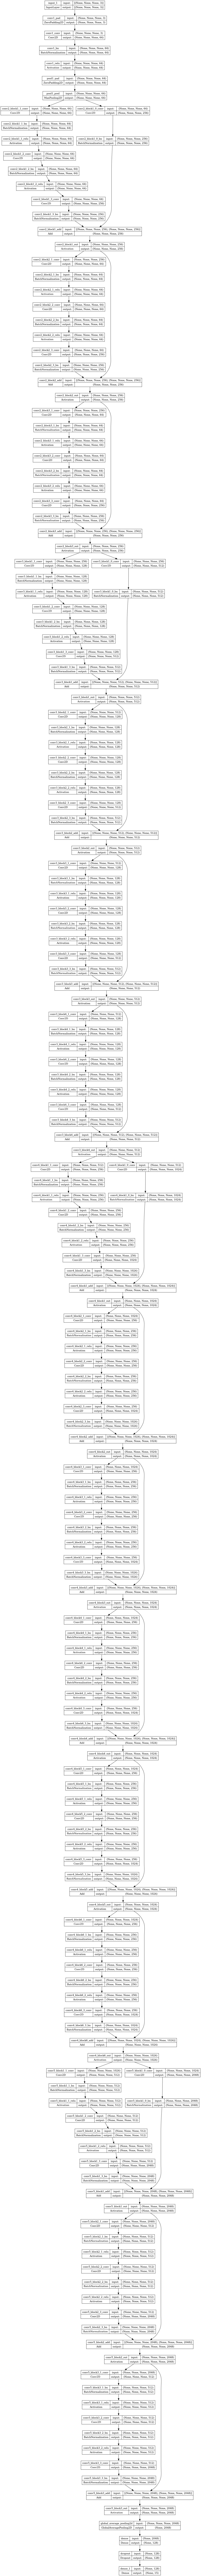

In [122]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)